## Inference

In this file we try to understand the relationship between prices (LMP and DA) vs the predictors: spot prices for natural gas, load demand, weather data

For lmp, we will try to infere the causality of 'real' values of the predictors whereas for DAMP we will infere the causality of forecasted values

In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from time import sleep
from utils import *
import numpy as np
import seaborn as sns
from linearmodels.system import SUR
import statsmodels.api as sm

c:\Users\benja\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
USERNAME = 'tmaret@uchicago.edu'
PASSWORD = 'PowerMarket2025'
SUBSCRIPTION_KEY = '9f1e472b26a5439d84f564bf038e46fa' 

# Authorization URL for signing into ERCOT Public API account
AUTH_URL = f'https://ercotb2c.b2clogin.com/ercotb2c.onmicrosoft.com/B2C_1_PUBAPI-ROPC-FLOW/oauth2/v2.0/token\
?username={USERNAME}\
&password={PASSWORD}\
&grant_type=password\
&scope=openid+fec253ea-0d06-4272-a5e6-b478baeecd70+offline_access\
&client_id=fec253ea-0d06-4272-a5e6-b478baeecd70\
&response_type=id_token'

# Sign In/Authenticate
auth_response = requests.post(AUTH_URL)

# Retrieve access token
access_token = auth_response.json().get("access_token")
print(auth_response)

<Response [200]>


In [3]:
list_of_zones = ['HB_HOUSTON', 'HB_WEST', 'HB_SOUTH', 'HB_NORTH', 'HB_PAN']

### 1. Inference on prices RT and DA for all hubs

It does not take long to download the data with the API but reccursively call it create request errors so the data is downloaded

In [4]:
## if need to download data

# da_lmp_houston = get_ercot_da_data(
#     start_date="2024-01-01",       
#     end_date="2025-02-25",        
#     settlement_point="HB_HOUSTON",
#     access_token=access_token,
#     subscription_key=SUBSCRIPTION_KEY
# )
# da_lmp_houston['deliveryDate'] = pd.to_datetime(da_lmp_houston['deliveryDate'])
# da_lmp_houston.to_csv('C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/Power_Market-1/Data/da_lmp_HB_HOUSTON.csv', index=False)
# da_lmp_houston.head()


## if data already downloaded : read it and concatenate it

da_data = pd.DataFrame()
for code in list_of_zones:
    lmp_da = pd.read_csv(f'C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/Power_Market-1/Data/da_lmp_{code}.csv')
    ## get hourly data
    lmp_da['deliveryDate'] = pd.to_datetime(lmp_da['deliveryDate'])
    lmp_da['hourEnding'] = lmp_da['hourEnding'].apply(lambda x: int(x.split(':')[0]))
    lmp_da = lmp_da.rename(columns={'settlementPointPrice': code+'_da', 'deliveryDate': 'date', 'hourEnding': 'hour'})[['date', 'hour', code+'_da']]
    if da_data.empty:
        da_data = lmp_da
    else:
        da_data = pd.merge(da_data, lmp_da, on=['date', 'hour'], how='outer')
da_data['date'] = pd.to_datetime(da_data['date'])
display(da_data)

,date,hour,HB_HOUSTON_da,HB_WEST_da,HB_SOUTH_da,HB_NORTH_da,HB_PAN_da
0,2024-01-01,1,15.84,19.79,14.55,16.31,16.97
1,2024-01-01,2,16.84,20.90,15.96,17.05,17.49
2,2024-01-01,3,16.78,21.34,16.31,16.79,17.31
3,2024-01-01,4,17.39,22.32,17.45,17.10,17.50
4,2024-01-01,5,19.01,23.68,18.54,18.87,19.48
...,...,...,...,...,...,...,...
10153,2025-02-25,20,34.94,36.93,31.31,36.17,36.42
10154,2025-02-25,21,28.64,28.91,25.19,28.79,28.13
10155,2025-02-25,22,23.74,22.65,20.67,23.23,21.82
10156,2025-02-25,23,20.90,20.52,18.52,20.61,19.29


In [5]:
rt_data = pd.DataFrame()
for code in list_of_zones:
    lmp_rt = pd.read_parquet(f'C:/Users/benja/OneDrive/Bureau/UchicagoMSFM/Power_Market-1/Data/rtm_LMP_{code}.parquet')
    ## get hourly data
    lmp_rt['SCEDTimestamp'] = pd.to_datetime(lmp_rt['SCEDTimestamp'])
    ## create a new df that aggregates all the LMPs for each hour : do equal weighted average
    lmp_rt['hour'] = lmp_rt['SCEDTimestamp'].dt.hour
    lmp_rt['date'] = lmp_rt['SCEDTimestamp'].dt.date

    rtm_hourly = lmp_rt.groupby(['date', 'hour'])['LMP'].mean().reset_index()
    rtm_hourly['date'] = pd.to_datetime(rtm_hourly['date'])

    rtm_hourly = rtm_hourly.rename(columns={'LMP': code+'_rt'})
    if rt_data.empty:
        rt_data = rtm_hourly
    else:
        rt_data = pd.merge(rt_data, rtm_hourly, on=['date', 'hour'], how='outer')
rt_data['date'] = pd.to_datetime(rt_data['date'])

display(rt_data)

,date,hour,HB_HOUSTON_rt,HB_WEST_rt,HB_SOUTH_rt,HB_NORTH_rt,HB_PAN_rt
0,2024-01-01,0,13.887500,15.500000,11.315000,14.876667,15.278333
1,2024-01-01,1,15.979167,16.703333,15.266667,16.088333,16.405000
2,2024-01-01,2,17.005000,17.005000,16.869167,17.005000,17.005000
3,2024-01-01,3,17.955000,17.955000,17.955000,17.955000,17.955000
4,2024-01-01,4,20.675833,20.675833,20.055000,20.675833,20.675833
...,...,...,...,...,...,...,...
10122,2025-02-25,19,24.463333,35.621667,20.020833,27.591667,32.412500
10123,2025-02-25,20,20.400000,24.528333,17.505000,21.844167,23.360000
10124,2025-02-25,21,16.276667,14.310833,15.208333,15.861667,14.620000
10125,2025-02-25,22,10.729167,5.801667,10.238333,9.490000,6.850000


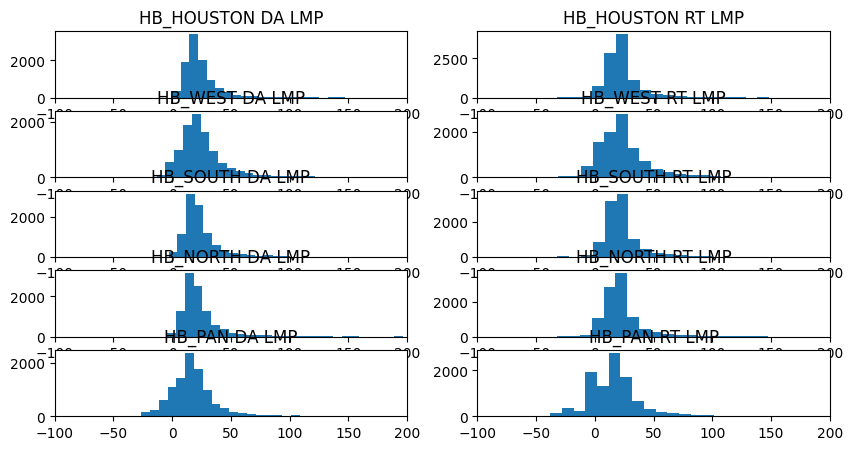

In [7]:
## show histograms of the LMPs
fig, ax = plt.subplots(len(list_of_zones), 2, figsize=(10, 5))
for code in list_of_zones:
    ax[list_of_zones.index(code), 0].hist(da_data[code+'_da'], bins=3*int(np.sqrt(len(da_data[code+'_da']))))
    ax[list_of_zones.index(code), 0].set_xlim(-100, 200)
    ax[list_of_zones.index(code), 0].set_title(f'{code} DA LMP')
    ax[list_of_zones.index(code), 1].hist(rt_data[code+'_rt'], bins=3*int(np.sqrt(len(rt_data[code+'_rt']))))
    ax[list_of_zones.index(code), 1].set_xlim(-100, 200)
    ax[list_of_zones.index(code), 1].set_title(f'{code} RT LMP')
plt.show()


### download predictors data : load data, gas spot price, weather data (solar and wind)

In [8]:
start_date = '2024-01-01'
end_date = '2025-03-01'
list_years = [2024, 2025]
# Load data
df_load = pd.DataFrame()
for year in list_years:
    # the file name is Natuve_Load_year.csv
    file_name = '../Data/Hourly_Load_Data/Native_Load_' + str(year) + '.xlsx'
    df_year = pd.read_excel(file_name)
    df_load = pd.concat([df_load, df_year], axis=0)
    
df_load['Hour Ending'] = pd.to_datetime(df_load['Hour Ending'], format='%m/%d/%Y %H:%M', errors='coerce')
df_load = df_load.set_index('Hour Ending')

In [9]:
mask = df_load.index.isnull()
indices = np.where(mask)[0]
index_list = list(df_load.index)

for i in indices:
    index_list[i] = index_list[i-1] + pd.DateOffset(hours=1)

# Assign the new index to the DataFrame
df_load.index = pd.Index(index_list)
df_load = df_load[~df_load.index.duplicated(keep='first')][['ERCOT']] ## for now we will only use ERCOT as a predictor
df_load = df_load.rename(columns={'ERCOT': 'load'})
df_load['date'] = df_load.index.date
df_load['date'] = pd.to_datetime(df_load['date'])
df_load['hour'] = df_load.index.hour
df_load = df_load.reset_index(drop=True)
df_load.head()

,load,date,hour
0,41223.480177,2024-01-01,1
1,41479.399746,2024-01-01,2
2,41472.770126,2024-01-01,3
3,41477.440791,2024-01-01,4
4,42184.192955,2024-01-01,5


In [10]:
## get gas data

# gas_spot_prices = pd.read_excel('../Data/NG_PRI_FUT_S1_D.xls', sheet_name = 'Data 1', skiprows=2)

# gas_spot_prices = gas_spot_prices.set_index('Date')
# ## keep values inside the date range
# gas_spot_prices = gas_spot_prices.loc[start_date:end_date]
# ## duplicate the index to have a date and an hour column


gas_spot_prices = pd.read_excel('../Data/NG_PRI_FUT_S1_D.xls', sheet_name='Data 1', skiprows=2)
gas_spot_prices = gas_spot_prices.set_index('Date')

# Keep values inside the date range
gas_spot_prices = gas_spot_prices.loc[start_date:end_date]

# Duplicate daily data into hourly data
hourly_data = []
for date, row in gas_spot_prices.iterrows():
    for hour in range(24):
        hourly_data.append([date + pd.Timedelta(hours=hour), row.values[0]])

hourly_gas_spot_prices = pd.DataFrame(hourly_data, columns=['Datetime', 'Price'])
hourly_gas_spot_prices = hourly_gas_spot_prices.set_index('Datetime')
gas_spot_prices = hourly_gas_spot_prices
gas_spot_prices = gas_spot_prices.rename(columns={'Price': 'gas_price'})
gas_spot_prices['date'] = gas_spot_prices.index.date
gas_spot_prices['date'] = pd.to_datetime(gas_spot_prices['date'])
gas_spot_prices['hour'] = gas_spot_prices.index.hour
gas_spot_prices = gas_spot_prices.reset_index(drop=True)
gas_spot_prices.head()

,gas_price,date,hour
0,2.56,2024-01-02,0
1,2.56,2024-01-02,1
2,2.56,2024-01-02,2
3,2.56,2024-01-02,3
4,2.56,2024-01-02,4


In [11]:
## get actual solar and wind data

df_wind_2024_actual = pd.read_parquet("../Data/df_wind_2024_actual.parquet")
# df_wind_2024_forecast = pd.read_parquet("../Data/df_wind_2024_forecast.parquet")
df_solar_2024_actual = pd.read_parquet("../Data/df_solar_2024_actual.parquet")
# df_solar_2024_forecast = pd.read_parquet("../Data/df_solar_2024_forecast.parquet")

#drop col with 'COPHS'
df_wind_2024_actual = df_wind_2024_actual.loc[:, ~df_wind_2024_actual.columns.str.contains('COPHS')]
df_solar_2024_actual = df_solar_2024_actual.loc[:, ~df_solar_2024_actual.columns.str.contains('COPHS')]

## rename column to identify if solar or wind (add wind or solar for all columns) except date, and hour
df_wind_2024_actual = df_wind_2024_actual.add_suffix('_wind')
df_wind_2024_actual = df_wind_2024_actual.rename(columns={'deliveryDate_wind': 'date', 'hourEnding_wind': 'hour'})
df_wind_2024_actual['date'] = pd.to_datetime(df_wind_2024_actual['date'])
df_wind_2024_actual = df_wind_2024_actual.drop(columns=['postedDatetime_wind'])
df_solar_2024_actual = df_solar_2024_actual.add_suffix('_solar')
df_solar_2024_actual = df_solar_2024_actual.rename(columns={'deliveryDate_solar': 'date', 'hourEnding_solar': 'hour'})
df_solar_2024_actual['date'] = pd.to_datetime(df_solar_2024_actual['date'])
df_solar_2024_actual = df_solar_2024_actual.drop(columns=['postedDatetime_solar'])


display(df_wind_2024_actual.head())
display(df_solar_2024_actual.head())

## check if perfect multicollinearity between wind columns and solar columns
df_solar_2024_actual.corr()


,date,hour,STWPFSystemWide_wind,STWPFPanhandle_wind,STWPFCoastal_wind,STWPFSouth_wind,STWPFWest_wind,STWPFNorth_wind
1,2024-01-01,1,15538.7,619.9,2430.8,1333.5,9260.7,1893.8
2,2024-01-01,2,14002.3,415.5,1909.1,1042.4,8744.2,1891.1
3,2024-01-01,3,13120.0,333.9,1527.7,721.9,8573.0,1963.5
4,2024-01-01,4,12114.8,217.9,1118.6,591.2,8295.8,1891.3
5,2024-01-01,5,11014.3,243.9,928.7,493.5,7620.6,1727.6


,date,hour,STPPFSystemWide_solar,STPPFCenterWest_solar,STPPFNorthWest_solar,STPPFFarWest_solar,STPPFFarEast_solar,STPPFSouthEast_solar,STPPFCenterEast_solar
1,2024-01-01,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2024-01-01,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2024-01-01,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2024-01-01,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2024-01-01,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,date,hour,STPPFSystemWide_solar,STPPFCenterWest_solar,STPPFNorthWest_solar,STPPFFarWest_solar,STPPFFarEast_solar,STPPFSouthEast_solar,STPPFCenterEast_solar
date,1.000000,-0.000186,0.080242,0.009200,0.067016,0.020153,0.124290,0.117630,0.094221
hour,-0.000186,1.000000,0.155616,0.162454,0.168765,0.177943,0.128439,0.154050,0.140488
STPPFSystemWide_solar,0.080242,0.155616,1.000000,0.964711,0.956323,0.956431,0.975264,0.955393,0.975103
STPPFCenterWest_solar,0.009200,0.162454,0.964711,1.000000,0.964715,0.960503,0.895492,0.899697,0.923003
STPPFNorthWest_solar,0.067016,0.168765,0.956323,0.964715,1.000000,0.945205,0.893732,0.891396,0.914254
STPPFFarWest_solar,0.020153,0.177943,0.956431,0.960503,0.945205,1.000000,0.878757,0.899263,0.892647
STPPFFarEast_solar,0.124290,0.128439,0.975264,0.895492,0.893732,0.878757,1.000000,0.936210,0.971103
STPPFSouthEast_solar,0.117630,0.154050,0.955393,0.899697,0.891396,0.899263,0.936210,1.000000,0.919845
STPPFCenterEast_solar,0.094221,0.140488,0.975103,0.923003,0.914254,0.892647,0.971103,0.919845,1.000000


we can see that the wind and solar production in regrions are highly correlated (>0.9). Therefore, we can keep on the the system wide production only as the predictors

In [12]:
df_solar_2024_actual = df_solar_2024_actual[['date', 'hour', 'STPPFSystemWide_solar']]
df_wind_2024_actual = df_wind_2024_actual[['date', 'hour', 'STWPFSystemWide_wind']]

## Regression on RT prices

### Concatene data

In [13]:
rt_dataset = pd.merge(df_load, gas_spot_prices, on=['date', 'hour'], how='outer')
rt_dataset = pd.merge(rt_dataset, rt_data, on=['date', 'hour'], how='outer')
rt_dataset = pd.merge(rt_dataset, df_wind_2024_actual, on=['date', 'hour'], how='outer')
rt_dataset = pd.merge(rt_dataset, df_solar_2024_actual, on=['date', 'hour'], how='outer')
rt_dataset = rt_dataset.dropna()

## show matrix of correlation with seaborn
display(rt_dataset.corr())

,load,date,hour,gas_price,HB_HOUSTON_rt,HB_WEST_rt,HB_SOUTH_rt,HB_NORTH_rt,HB_PAN_rt,STWPFSystemWide_wind,STPPFSystemWide_solar
load,1.000000,1.690134e-01,4.482535e-01,5.507878e-02,0.171486,0.145317,0.177273,0.165980,0.169630,-0.162043,0.459619
date,0.169013,1.000000e+00,-1.561423e-15,1.261231e-01,-0.003984,0.003291,-0.000246,0.005944,-0.000817,-0.096962,0.090583
hour,0.448254,-1.561423e-15,1.000000e+00,-2.831374e-17,0.108089,0.110868,0.111936,0.105975,0.087418,-0.103857,0.233290
gas_price,0.055079,1.261231e-01,-2.831374e-17,1.000000e+00,0.000394,0.007386,-0.003140,0.007950,0.023509,-0.016157,-0.010335
HB_HOUSTON_rt,0.171486,-3.983949e-03,1.080893e-01,3.944341e-04,1.000000,0.972081,0.988880,0.990888,0.964437,-0.114322,0.032295
HB_WEST_rt,0.145317,3.290880e-03,1.108679e-01,7.386045e-03,0.972081,1.000000,0.969660,0.980917,0.969647,-0.191258,-0.012877
HB_SOUTH_rt,0.177273,-2.457823e-04,1.119359e-01,-3.140237e-03,0.988880,0.969660,1.000000,0.981554,0.955817,-0.128622,0.030240
HB_NORTH_rt,0.165980,5.944199e-03,1.059746e-01,7.949796e-03,0.990888,0.980917,0.981554,1.000000,0.977733,-0.128502,0.022151
HB_PAN_rt,0.169630,-8.166492e-04,8.741841e-02,2.350903e-02,0.964437,0.969647,0.955817,0.977733,1.000000,-0.197540,0.036210
STWPFSystemWide_wind,-0.162043,-9.696230e-02,-1.038569e-01,-1.615667e-02,-0.114322,-0.191258,-0.128622,-0.128502,-0.197540,1.000000,-0.278042


In [18]:
## for the regression we transform date into day of the week and month
rt_dataset['day_of_week'] = rt_dataset['date'].dt.dayofweek
rt_dataset['month'] = rt_dataset['date'].dt.month
rt_dataset['month'] = rt_dataset['month'].astype('category')
rt_dataset['day_of_week'] = rt_dataset['day_of_week'].astype('category')
rt_dataset['hour'] = rt_dataset['hour'].astype('category')
response_col = ['HB_HOUSTON_rt', 'HB_WEST_rt', 'HB_SOUTH_rt', 'HB_NORTH_rt', 'HB_PAN_rt']
predictors = [col for col in rt_dataset.columns if col not in response_col]
predictors.remove('date')

In [19]:
predictors

['load',
 'hour',
 'gas_price',
 'STWPFSystemWide_wind',
 'STPPFSystemWide_solar',
 'day_of_week',
 'month']

In [20]:

## we model response columns as a function of all the predictors
## we will have 5 equations, one for each response column
predictor_str = ' + '.join(predictors)

equations = {
    'hub1': f'HB_HOUSTON_rt ~ {predictor_str}',
    'hub2': f'HB_WEST_rt ~ {predictor_str}',
    'hub3': f'HB_SOUTH_rt ~ {predictor_str}',
    'hub4': f'HB_NORTH_rt ~ {predictor_str}',
    'hub5': f'HB_PAN_rt ~ {predictor_str}'
}

# Fit the SUR model
mod = SUR.from_formula(equations, data=rt_dataset)
results = mod.fit()

# Print the summary of results
print(results.summary)

                           System GLS Estimation Summary                           
Estimator:                        GLS   Overall R-squared:                   0.0995
No. Equations.:                     5   McElroy's R-squared:                 0.1353
No. Observations:                5773   Judge's (OLS) R-squared:             0.0995
Date:                Fri, Mar 14 2025   Berndt's R-squared:                  0.4977
Time:                        16:48:18   Dhrymes's R-squared:                 0.0995
                                        Cov. Estimator:                      robust
                                        Num. Constraints:                      None
                    Equation: hub1, Dependent Variable: HB_HOUSTON_rt                    
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
load                      0.0021     0.0002     8.6938    

We see that the predictors are statistically significant (low p-values) but the relationship between the predictors and the response is not linear (low R^2)

Let's run a multi-nomial regression on predictors vs spikes of spread (-1 if negative price spike, +1 if positive price spike, 0 else)

In [39]:
## define a spike label column
spread_dt = pd.DataFrame()
spread_dt['month'] = rt_dataset['month'] 
spread_dt['day_of_week'] = rt_dataset['day_of_week']
spread_dt['hour'] = rt_dataset['hour']
spread_dt['date'] = rt_dataset['date']
concat = pd.merge(da_data, rt_data, on=['date', 'hour'], how='outer')
for code in list_of_zones:
    spread_dt[code +'_spread'] =  concat[code+'_da'] - concat[code+'_rt']
    spread_dt[code +'_spike'] = spread_dt[code +'_spread'].apply(lambda x: 1 if x > 50 else (-1 if x < -50 else 0))
    ## rolling window of the last 96 hours to last 48 hours of the average of spike label
    st_spike_sum = spread_dt[code +'_spike'].rolling(48).sum()
    lt_spike_sum = spread_dt[code +'_spike'].rolling(96).sum()
    spread_dt[code +'_avg_last_spike'] = (lt_spike_sum - st_spike_sum)/48
spread_dt = pd.merge(spread_dt, gas_spot_prices, on=['date', 'hour'], how='outer')
spread_dt = pd.merge(spread_dt, df_load, on=['date', 'hour'], how='outer')
spread_dt = pd.merge(spread_dt, df_wind_2024_actual, on=['date', 'hour'], how='outer')
spread_dt = pd.merge(spread_dt, df_solar_2024_actual, on=['date', 'hour'], how='outer')
spread_dt = spread_dt.dropna()

spread_dt.describe()

,hour,date,HB_HOUSTON_spread,HB_HOUSTON_spike,HB_HOUSTON_avg_last_spike,HB_WEST_spread,HB_WEST_spike,HB_WEST_avg_last_spike,HB_SOUTH_spread,HB_SOUTH_spike,...,HB_NORTH_spread,HB_NORTH_spike,HB_NORTH_avg_last_spike,HB_PAN_spread,HB_PAN_spike,HB_PAN_avg_last_spike,gas_price,load,STWPFSystemWide_wind,STPPFSystemWide_solar
count,5600.000000,5600,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,...,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000,5600.000000
mean,12.095893,2024-07-02 07:26:54.857142528,1.346547,0.002857,0.003344,1.416003,0.000893,0.001637,1.174336,0.001786,...,1.101991,0.003393,0.004036,1.559652,0.006964,0.007645,2.176029,53193.143634,13271.191857,6021.277357
min,1.000000,2024-01-08 00:00:00,-2784.165714,-1.000000,-0.250000,-2749.602857,-1.000000,-0.187500,-2805.918571,-1.000000,...,-2765.710714,-1.000000,-0.187500,-2755.485714,-1.000000,-0.187500,1.210000,35855.647755,177.200000,0.000000
25%,6.000000,2024-04-04 18:00:00,-3.608958,0.000000,-0.020833,-4.377708,0.000000,-0.020833,-3.132083,0.000000,...,-4.053333,0.000000,-0.020833,-5.009792,0.000000,-0.020833,1.740000,45427.892051,6761.600000,0.000000
50%,12.000000,2024-07-02 00:00:00,0.766250,0.000000,0.000000,1.743750,0.000000,0.000000,1.230000,0.000000,...,0.848333,0.000000,0.000000,0.627692,0.000000,0.000000,2.100000,50189.044934,12340.400000,1178.800000
75%,18.000000,2024-09-27 00:00:00,6.364792,0.000000,0.000000,8.203958,0.000000,0.020833,6.548333,0.000000,...,6.311042,0.000000,0.020833,7.875048,0.000000,0.020833,2.450000,59296.872435,19468.125000,12694.400000
max,23.000000,2024-12-31 00:00:00,1806.578462,1.000000,0.479167,1882.021667,1.000000,0.562500,1795.089231,1.000000,...,1868.623333,1.000000,0.520833,1866.793333,1.000000,0.562500,13.200000,85198.850050,31839.600000,21916.900000
std,6.632435,NaN,76.116003,0.211288,0.062992,79.168587,0.230314,0.067798,74.854757,0.215485,...,78.321543,0.214218,0.061634,79.023757,0.223118,0.065060,0.866192,10633.711488,7548.493235,7066.189350


In [82]:
hubs = ['HB_HOUSTON_spread', 'HB_WEST_spread', 'HB_SOUTH_spread', 'HB_NORTH_spread', 'HB_PAN_spread']
stats = spread_dt[hubs].describe().loc[['mean', 'std']]
stats.index = ['Average Spread', 'Standard Deviation Spread']

display(stats)

,HB_HOUSTON_spread,HB_WEST_spread,HB_SOUTH_spread,HB_NORTH_spread,HB_PAN_spread
Average Spread,1.346547,1.416003,1.174336,1.101991,1.559652
Standard Deviation Spread,76.116003,79.168587,74.854757,78.321543,79.023757


In [85]:
spikes_ratio = pd.DataFrame()
for hub in list_of_zones:
    ratio = spread_dt[hub + '_spike'].value_counts(normalize=True)
    spikes_ratio[hub + '_spike'] = ratio
    print(f'{hub} : {ratio}')
spikes_ratio.rename(index={1: 'Up', 0: 'No spike', -1: 'Down'}, inplace=True)
display(spikes_ratio)

HB_HOUSTON : HB_HOUSTON_spike
 0.0    0.955357
 1.0    0.023750
-1.0    0.020893
Name: proportion, dtype: float64
HB_WEST : HB_WEST_spike
 0.0    0.946964
 1.0    0.026964
-1.0    0.026071
Name: proportion, dtype: float64
HB_SOUTH : HB_SOUTH_spike
 0.0    0.953571
 1.0    0.024107
-1.0    0.022321
Name: proportion, dtype: float64
HB_NORTH : HB_NORTH_spike
 0.0    0.954107
 1.0    0.024643
-1.0    0.021250
Name: proportion, dtype: float64
HB_PAN : HB_PAN_spike
 0.0    0.950179
 1.0    0.028393
-1.0    0.021429
Name: proportion, dtype: float64


,HB_HOUSTON_spike,HB_WEST_spike,HB_SOUTH_spike,HB_NORTH_spike,HB_PAN_spike
HB_HOUSTON_spike,,,,,
No spike,0.955357,0.946964,0.953571,0.954107,0.950179
Up,0.023750,0.026964,0.024107,0.024643,0.028393
Down,0.020893,0.026071,0.022321,0.021250,0.021429


### observe if previous spikes values have an impact on the following

average of last spike label for when spike label is 1 for HOUSTON: -0.007675438596491228
average of last spike label for when spike label is 0 for HOUSTON: 0.0028660436137071654
average of last spike label for when spike label is -1 for HOUSTON: 0.03774928774928775


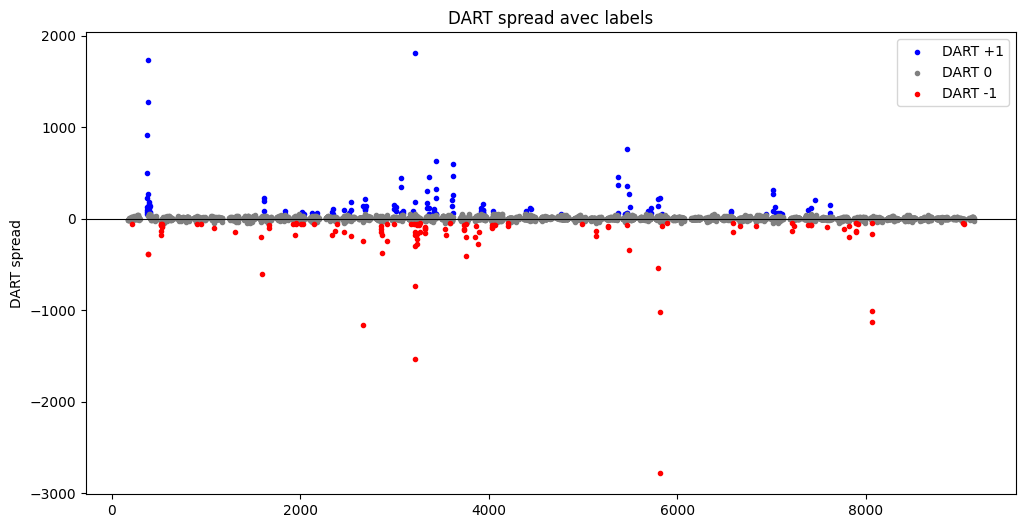

,Hub,Spike Label,Average Last Spike
0,HOUSTON,1,-0.008
1,HOUSTON,0,0.003
2,HOUSTON,-1,0.038
3,NORTH,1,-0.005
4,NORTH,0,0.004
5,NORTH,-1,0.035
6,WEST,1,-0.003
7,WEST,0,0.001
8,WEST,-1,0.032
9,SOUTH,1,-0.008


In [51]:
## get average of last spike label for when spike label is 1 for Houston
mask = spread_dt['HB_HOUSTON_spike'] == 1
avg_spike_1_houston = spread_dt[mask]['HB_HOUSTON_avg_last_spike'].mean()
print(f'average of last spike label for when spike label is 1 for HOUSTON: {avg_spike_1_houston}')

## get average of last spike label for when spike label is 0 for Houston
mask = spread_dt['HB_HOUSTON_spike'] == 0
avg_spike_0_houston = spread_dt[mask]['HB_HOUSTON_avg_last_spike'].mean()
print(f'average of last spike label for when spike label is 0 for HOUSTON: {avg_spike_0_houston}')

## get average of last spike label for when spike label is -1 for Houston
mask = spread_dt['HB_HOUSTON_spike'] == -1
avg_spike_m1_houston = spread_dt[mask]['HB_HOUSTON_avg_last_spike'].dropna().mean()
print(f'average of last spike label for when spike label is -1 for HOUSTON: {avg_spike_m1_houston}')


# Séparer les données par labels
df_pos = spread_dt[spread_dt['HB_HOUSTON_spike'] == 1][['HB_HOUSTON_spread']]
df_neutre = spread_dt[spread_dt['HB_HOUSTON_spike'] == 0][['HB_HOUSTON_spread']]
df_neg = spread_dt[spread_dt['HB_HOUSTON_spike'] == -1][['HB_HOUSTON_spread']]

# Tracé des graphiques
plt.figure(figsize=(12, 6))

plt.scatter(df_pos.index, df_pos['HB_HOUSTON_spread'], color='blue', label='DART +1',marker=".")
plt.scatter(df_neutre.index, df_neutre['HB_HOUSTON_spread'], color='grey', label='DART 0',marker=".")
plt.scatter(df_neg.index, df_neg['HB_HOUSTON_spread'], color='red', label='DART -1',marker=".")

plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.title('DART spread avec labels for HOUSTON')
plt.ylabel('DART spread')
plt.show()

results = []

# Define the hubs
hubs = ['HOUSTON', 'NORTH', 'WEST', 'SOUTH']
labels = [1, 0, -1]

# Iterate through hubs and labels to calculate means
for hub in hubs:
    for label in labels:
        mask = spread_dt[f'HB_{hub}_spike'] == label
        avg_spike = spread_dt[mask][f'HB_{hub}_avg_last_spike'].dropna().mean()
        results.append({'Hub': hub, 'Spike Label': label, 'Average Last Spike': avg_spike})

# Convert results to DataFrame
summary_df = pd.DataFrame(results)

# Display the summary table with styling
styled_summary = summary_df.style.format({'Average Last Spike': '{:.3f}'}).set_caption('Average Last Spike by Hub and Spike Label')
print(styled_summary)

# Optionally, to display it nicely in Jupyter Notebooks or similar environments
display(styled_summary)

we can see a negative relationship between the spike label and the previous ones

### run multinomial regression on all hubs

In [64]:
from sklearn.metrics import confusion_matrix
spread_df_temp = spread_dt.copy().dropna()
predictors_label = predictors + ['HB_HOUSTON_avg_last_spike']
X = sm.add_constant(spread_df_temp[predictors_label])
y = spread_df_temp['HB_HOUSTON_spike']

# Fit the multinomial logistic regression model
model = sm.MNLogit(y, X)
result = model.fit()

# View the summary
print(result.summary())

# Get predicted classes (choose the class with the highest probability)
y_pred = result.predict(X).idxmax(axis=1)

# Ensure y_pred is in the same format as y for confusion matrix
y_pred = y_pred.astype(int)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred)
print('Confusion Matrix:')
print(cm)


Optimization terminated successfully.
         Current function value: 0.161422
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:       HB_HOUSTON_spike   No. Observations:                 5600
Model:                        MNLogit   Df Residuals:                     5582
Method:                           MLE   Df Model:                           16
Date:                Fri, 14 Mar 2025   Pseudo R-squ.:                  0.2431
Time:                        18:29:39   Log-Likelihood:                -903.96
converged:                       True   LL-Null:                       -1194.4
Covariance Type:            nonrobust   LLR p-value:                2.666e-113
       HB_HOUSTON_spike=0       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         3.4272      0.657      5.213      0.000       2

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd

# Define predictor matrix X and outcome y
X = spread_df_temp[predictors_label]   # predictors: list of predictor column names
y = spread_df_temp['HB_HOUSTON_spike']

# Split the data: 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on training data
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Calculate and display the confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[   7   29    0]
 [   0 1597    0]
 [   0   33   14]]

Classification Report:
              precision    recall  f1-score   support

        -1.0       1.00      0.19      0.33        36
         0.0       0.96      1.00      0.98      1597
         1.0       1.00      0.30      0.46        47

    accuracy                           0.96      1680
   macro avg       0.99      0.50      0.59      1680
weighted avg       0.96      0.96      0.95      1680



+1 and -1 are under-represented in the dataset so we need to adapt the loss weights so that it gives equal importance

In [73]:
import pandas as pd
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Assume spread_df_temp is your full dataset and predictors is your list of predictor column names.
# Make sure predictors is defined correctly (and use the same variable name everywhere)
X = spread_df_temp[predictors]  
y = spread_df_temp['HB_HOUSTON_spike']

# Split into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Combine X_train and y_train for easier manipulation
train_data = pd.concat([X_train, y_train], axis=1)

# Separate the classes
data_class0   = train_data[train_data['HB_HOUSTON_spike'] == 0]
data_class_neg1 = train_data[train_data['HB_HOUSTON_spike'] == -1]
data_class_1  = train_data[train_data['HB_HOUSTON_spike'] == 1]

# Upsample the minority classes (-1 and 1) to match the number of observations in class 0
data_class_neg1_upsampled = resample(data_class_neg1,
                                     replace=True,
                                     n_samples=len(data_class0),
                                     random_state=42)

data_class_1_upsampled = resample(data_class_1,
                                  replace=True,
                                  n_samples=len(data_class0),
                                  random_state=42)

# Combine the upsampled data with the majority class
train_data_balanced = pd.concat([data_class0, data_class_neg1_upsampled, data_class_1_upsampled])

# Separate predictors and target from the balanced dataset
X_train_balanced = train_data_balanced[predictors]
y_train_balanced = train_data_balanced['HB_HOUSTON_spike']

# Optionally, ensure that X_test has the same columns and order as X_train_balanced
X_test = X_test[X_train_balanced.columns]

# Fit a Random Forest on the balanced training data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

# Evaluate on the test set
y_pred = rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[   7   28    1]
 [   5 1589    3]
 [   0   26   21]]

Classification Report:
              precision    recall  f1-score   support

        -1.0       0.58      0.19      0.29        36
         0.0       0.97      0.99      0.98      1597
         1.0       0.84      0.45      0.58        47

    accuracy                           0.96      1680
   macro avg       0.80      0.55      0.62      1680
weighted avg       0.96      0.96      0.95      1680

